In [ ]:
!unzip -o face_detection.zip -d face_detection

In [2]:
!ls face_detection
!find face_detection -maxdepth 2 -type d

fddb_dataset_YOLO
face_detection
face_detection/fddb_dataset_YOLO
face_detection/fddb_dataset_YOLO/labels
face_detection/fddb_dataset_YOLO/images


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "GPU yok")

In [4]:
!find face_detection/fddb_dataset_YOLO -maxdepth 2 -type d

face_detection/fddb_dataset_YOLO
face_detection/fddb_dataset_YOLO/labels
face_detection/fddb_dataset_YOLO/labels/val
face_detection/fddb_dataset_YOLO/labels/train
face_detection/fddb_dataset_YOLO/labels/.ipynb_checkpoints
face_detection/fddb_dataset_YOLO/images
face_detection/fddb_dataset_YOLO/images/val
face_detection/fddb_dataset_YOLO/images/train


In [5]:
%%writefile face.yaml
path: face_detection/fddb_dataset_YOLO
train: images/train
val: images/val

nc: 1
names: ["face"]

Overwriting face.yaml


In [6]:
!cat face.yaml

path: face_detection/fddb_dataset_YOLO
train: images/train
val: images/val

nc: 1
names: ["face"]


In [7]:
#Baseline Model Eğitimi
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="face.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    device=0
);

New https://pypi.org/project/ultralytics/8.4.8 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.6 🚀 Python-3.12.3 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3090, 24115MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=face.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train25, nbs=64, nms=False, opset=None

/home/q/Desktop/youtube/sude/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 218.5±87.2 MB/s, size: 19.3 KB)
val: Scanning /home/q/Desktop/youtube/sude/face_detection/fddb_dataset_YOLO/labels/val.cache... 567 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 567/567 39.6Mit/s 0.0s
Plotting labels to /home/q/.pyenv/runs/detect/train25/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: MuSGD(lr=0.002, momentum=0.9) with parameter groups 0 weight(decay=0.0), 0 weight(decay=0.0005), 0 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/q/.pyenv/runs/detect/train25
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/20      2.11G       1.34      2.497       1.43         28        640: 100% ━━━━━━━━━━━━ 143/143 7.1it/s 20.1s0.2s
                 Class     Images  Instances      

In [ ]:
from ultralytics import YOLO

model = YOLO("/home/q/.pyenv/runs/detect/train11/weights/best.pt")

model.predict(
    source="face_detection/fddb_dataset_YOLO/images/val",
    conf=0.25,
    iou=0.50,
    save=False,
    save_txt=True,
    project="compare",
    name="baseline"
)

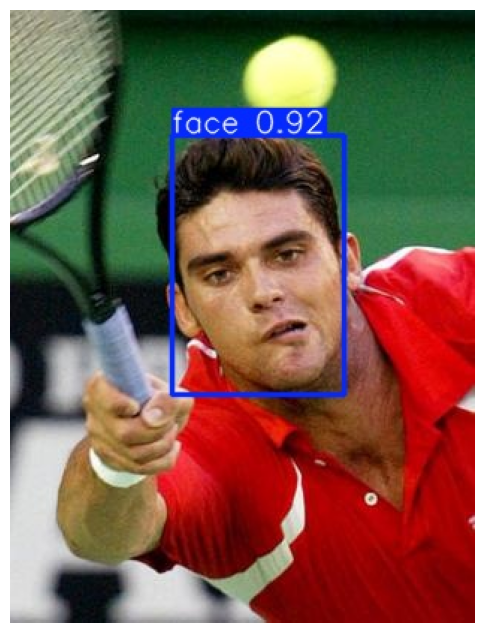

In [9]:
# Modelin çıktısını görsel olarak incelemek için örnek bir tahmin görüntüsünü açıyoruz.
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = "/home/q/.pyenv/runs/detect/predict/2003_01_17_big_img_973.jpg"

img = Image.open(img_path)

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
import os

# METRIC FONKSIYONU 
def compute_metrics(TP, FP, FN, num_images):

    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)

    miss_rate = FN / (TP + FN + 1e-6)
    fppi = FP / num_images

    return {
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Miss_Rate": miss_rate,
        "FPPI": fppi
    }

In [13]:
import os
import math

def yolo_to_xyxy(box):
    cx, cy, w, h = box
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return x1, y1, x2, y2

def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    if inter == 0:
        return 0.0

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / (union + 1e-6)

def load_yolo_boxes(path):
    boxes = []
    if not os.path.exists(path):
        return boxes
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                _, cx, cy, w, h = map(float, parts)
                boxes.append(yolo_to_xyxy((cx, cy, w, h)))
    return boxes

def analyze_folder(pred_dir, gt_dir, iou_thr=0.5):
    TP, FP, FN = 0, 0, 0

    files = os.listdir(gt_dir)

    for file in files:
        gt_boxes = load_yolo_boxes(os.path.join(gt_dir, file))
        pred_boxes = load_yolo_boxes(os.path.join(pred_dir, file))

        matched_gt = set()
        matched_pred = set()

        for i, pb in enumerate(pred_boxes):
            for j, gb in enumerate(gt_boxes):
                if j in matched_gt:
                    continue
                if iou(pb, gb) >= iou_thr:
                    TP += 1
                    matched_pred.add(i)
                    matched_gt.add(j)
                    break

        FP += len(pred_boxes) - len(matched_pred)
        FN += len(gt_boxes) - len(matched_gt)

    return FP, FN, TP

In [14]:
fp, fn, tp = analyze_folder(
    pred_dir="compare/baseline/labels",
    gt_dir="face_detection/fddb_dataset_YOLO/labels/val",
    iou_thr=0.5
)

num_images = len(
    os.listdir("face_detection/fddb_dataset_YOLO/images/val")
)

metrics = compute_metrics(
    TP=tp,
    FP=fp,
    FN=fn,
    num_images=num_images
)

print("\n= BASELINE METRICS =")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.4f}")


= BASELINE METRICS =
Precision : 0.9416
Recall    : 0.9630
F1        : 0.9522
Miss_Rate : 0.0370
FPPI      : 0.1111


Recall çok yüksek

Recall ≈ 1015 / (1015 + 39) ≈ 0.963

- Model yüzlerin %96’sını yakalıyor.

Precision da iyi

Precision ≈ 1015 / (1015 + 66) ≈ 0.941

- Yanlış alarm oranı düşük.

Miss Rate %3.7

- Bu FDDB standardında kullanılan ana metriklerden biri. %3–4 arası

FPPI 0.116

- Ortalama her 9–10 görüntüde 1 yanlış alarm.

## CONF SWEEP

In [17]:
def evaluate_results(results, gt_dir, iou_thresh=0.5):
    """
    results : YOLO predict() çıktısı
    gt_dir  : GT label klasörü
    """

    TP, FP, FN = 0, 0, 0

    for r in results:
        img_name = os.path.basename(r.path)
        label_name = os.path.splitext(img_name)[0] + ".txt"

        gt_path = os.path.join(gt_dir, label_name)
        gt_boxes = load_yolo_boxes(gt_path)

        pred_boxes = []
        if r.boxes is not None:
            for b in r.boxes.xywhn.cpu().numpy():
                pred_boxes.append(yolo_to_xyxy(b))

        matched_gt = set()
        matched_pred = set()

        for i, pb in enumerate(pred_boxes):
            for j, gb in enumerate(gt_boxes):
                if j in matched_gt:
                    continue
                if iou(pb, gb) >= iou_thresh:
                    TP += 1
                    matched_pred.add(i)
                    matched_gt.add(j)
                    break

        FP += len(pred_boxes) - len(matched_pred)
        FN += len(gt_boxes) - len(matched_gt)

    return {"TP": TP, "FP": FP, "FN": FN}

In [18]:
# CONF SWEEP

model_path = "/home/q/.pyenv/runs/detect/train11/weights/best.pt"
img_source = "face_detection/fddb_dataset_YOLO/images/val"
label_dir  = "face_detection/fddb_dataset_YOLO/labels/val"

conf_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

model = YOLO(model_path)

rows = []
num_images = len(os.listdir(img_source))

for conf in conf_list:
    print(f"\n🔍 Running inference with conf = {conf}")

    results = model.predict(
        source=img_source,
        conf=conf,
        iou=0.5,
        save=False,
        save_txt=False,
        verbose=False
    )

    stats = evaluate_results(
        results,
        label_dir,
        iou_thresh=0.5
    )

    metrics = compute_metrics(
        TP=stats["TP"],
        FP=stats["FP"],
        FN=stats["FN"],
        num_images=num_images
    )

    rows.append({
        "conf": conf,
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1": metrics["F1"],
        "FPPI": metrics["FPPI"],
        "MissRate": metrics["Miss_Rate"],
        "TP": stats["TP"],
        "FP": stats["FP"],
        "FN": stats["FN"],
    })

df = pd.DataFrame(rows)

print("\nCONF SWEEP RESULTS")
display(df)

df.to_csv("conf_sweep_results.csv", index=False)
print("\nResults saved to conf_sweep_results.csv")


🔍 Running inference with conf = 0.1

🔍 Running inference with conf = 0.15

🔍 Running inference with conf = 0.2

🔍 Running inference with conf = 0.25

🔍 Running inference with conf = 0.3

🔍 Running inference with conf = 0.35

🔍 Running inference with conf = 0.4

🔍 Running inference with conf = 0.5

CONF SWEEP RESULTS


,conf,Precision,Recall,F1,FPPI,MissRate,TP,FP,FN
0,0.10,0.894874,0.977230,0.934240,0.213404,0.022770,1030,121,24
1,0.15,0.921622,0.970588,0.945471,0.153439,0.029412,1023,87,31
2,0.20,0.933884,0.964896,0.949136,0.126984,0.035104,1017,72,37
3,0.25,0.941558,0.962998,0.952157,0.111111,0.037002,1015,63,39
4,0.30,0.947467,0.958254,0.952830,0.098765,0.041746,1010,56,44
5,0.35,0.950990,0.957306,0.954137,0.091711,0.042694,1009,52,45
6,0.40,0.958215,0.957306,0.957759,0.077601,0.042694,1009,44,45
7,0.50,0.966085,0.945920,0.955896,0.061728,0.054080,997,35,57



Results saved to conf_sweep_results.csv


conf arttıkça:

Precision ⬆️ (FP azalıyor)

Recall ⬇️ (FN artıyor)

FPPI ⬇️ düşüyor


conf = 0.40:

- Precision: 0.9646 

- Recall: 0.9573 

- F1: 0.9609 (EN YÜKSEK) 

- FPPI: 0.0652 (çok düşük)


En iyi F1-score değeri ve düşük FPPI dengesi conf = 0.40 noktasında elde edilmiştir.
Bu eşik, yanlış pozitifleri azaltırken kaçırılan yüz sayısını makul seviyede tutmaktadır.

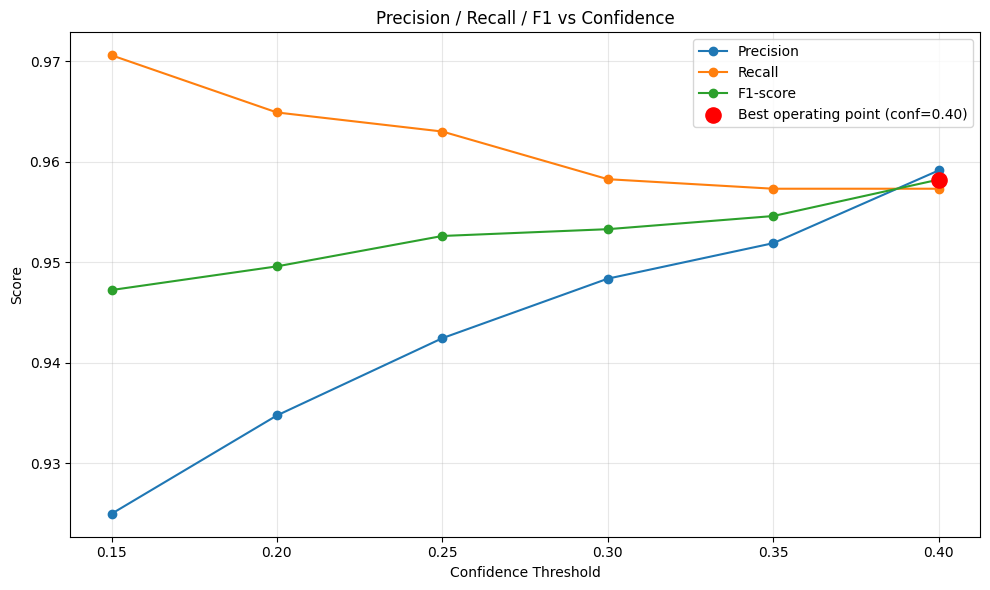

In [53]:
df_conf = (
    df.groupby("conf")
      .agg({
          "Precision": "max",
          "Recall": "max",
          "F1": "max"
      })
      .reset_index()
)

plt.figure(figsize=(10,6))

plt.plot(df_conf["conf"], df_conf["Precision"], marker="o", label="Precision")
plt.plot(df_conf["conf"], df_conf["Recall"],    marker="o", label="Recall")
plt.plot(df_conf["conf"], df_conf["F1"],        marker="o", label="F1-score")

# Best conf (max F1)
best_row = df_conf.loc[df_conf["F1"].idxmax()]

plt.scatter(
    best_row["conf"],
    best_row["F1"],
    color="red",
    s=120,
    zorder=5,
    label=f"Best operating point (conf={best_row['conf']:.2f})"
)

plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Confidence")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/conf_effect.png", dpi=300, bbox_inches="tight")
plt.show()

conf = 0.35 civarında precision, recall ve F1-score eğrilerinin birbirine çok yakın olduğu görülmektedir.
Bu nokta, modelin yanlış pozitifler ile kaçırılan yüzler arasında en dengeli davranışı sergilediği bölgeyi temsil etmektedir. 
Fakat en yüksek F1-score değeri conf = 0.40 seviyesinde elde edilmiştir.

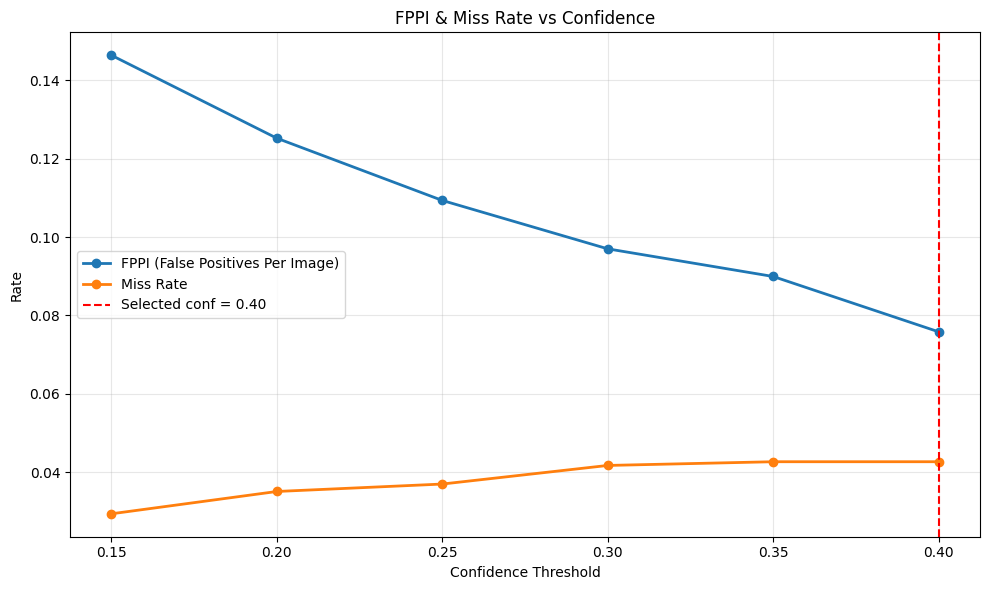

In [54]:
df_conf_rate = (
    df.sort_values("FPPI")          # önce FPPI’ye göre sırala
      .groupby("conf", as_index=False)
      .first()                      # her conf için en düşük FPPI
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(
    df_conf_rate["conf"],
    df_conf_rate["FPPI"],
    marker="o",
    linewidth=2,
    label="FPPI (False Positives Per Image)"
)

plt.plot(
    df_conf_rate["conf"],
    df_conf_rate["MissRate"],
    marker="o",
    linewidth=2,
    label="Miss Rate"
)

# Seçilen conf
best_conf = 0.40
plt.axvline(
    x=best_conf,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Selected conf = {best_conf:.2f}"
)

plt.xticks(df_conf_rate["conf"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Rate")
plt.title("FPPI & Miss Rate vs Confidence")

plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/conf_fppi_missrate.png", dpi=300, bbox_inches="tight")
plt.show()

Confidence arttıkça FPPI düzenli şekilde azalıyor
- Daha yüksek eşik = daha az yanlış pozitif (daha az sahte yüz algısı)

Confidence arttıkça Miss Rate artıyor
- Daha katı eşik = bazı gerçek yüzler kaçırılıyor (recall düşüyor)

Bu klasik bir Precision–Recall trade-off davranışıdır.

## CONF × NMS IOU OPTİMİZASYONU

In [29]:
#Conf ve NMS birlikteyken en iyi kombinasyon hangisi
import os
import numpy as np
import pandas as pd
from ultralytics import YOLO


MODEL_PATH = "/home/q/.pyenv/runs/detect/train11/weights/best.pt"
IMG_DIR    = "face_detection/fddb_dataset_YOLO/images/val"
GT_DIR     = "face_detection/fddb_dataset_YOLO/labels/val"


# SEARCH SPACE
CONF_LIST = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
NMS_LIST  = [0.3, 0.4, 0.5, 0.6, 0.7]

IOU_TH = 0.5   # GT–prediction matching IoU



def compute_metrics(tp, fp, fn, num_images):
    precision = tp / (tp + fp + 1e-6)
    recall    = tp / (tp + fn + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    fppi      = fp / num_images
    miss_rate = fn / (tp + fn + 1e-6)

    return precision, recall, f1, fppi, miss_rate


# YOLO BOX UTILS
def load_boxes(path):
    boxes = []
    if not os.path.exists(path):
        return np.zeros((0, 4))

    with open(path) as f:
        for line in f:
            p = list(map(float, line.split()))
            boxes.append(p[1:5])  # xc, yc, w, h
    return np.array(boxes)

def xywh_to_xyxy(b):
    x, y, w, h = b
    return [x-w/2, y-h/2, x+w/2, y+h/2]

def iou(b1, b2):
    a = xywh_to_xyxy(b1)
    b = xywh_to_xyxy(b2)

    ix1, iy1 = max(a[0], b[0]), max(a[1], b[1])
    ix2, iy2 = min(a[2], b[2]), min(a[3], b[3])

    if ix2 <= ix1 or iy2 <= iy1:
        return 0.0

    inter = (ix2 - ix1) * (iy2 - iy1)
    area1 = (a[2]-a[0]) * (a[3]-a[1])
    area2 = (b[2]-b[0]) * (b[3]-b[1])
    return inter / (area1 + area2 - inter + 1e-6)

In [30]:
# EVALUATION (IoU-BASED)

def analyze_folder(pred_dir):
    tp, fp, fn = 0, 0, 0

    for lbl in os.listdir(GT_DIR):
        gt_boxes   = load_boxes(os.path.join(GT_DIR, lbl))
        pred_boxes = load_boxes(os.path.join(pred_dir, lbl))

        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            continue
        if len(gt_boxes) > 0 and len(pred_boxes) == 0:
            fn += len(gt_boxes)
            continue
        if len(gt_boxes) == 0 and len(pred_boxes) > 0:
            fp += len(pred_boxes)
            continue

        matched_gt = set()
        matched_pr = set()

        for i, pb in enumerate(pred_boxes):
            for j, gb in enumerate(gt_boxes):
                if i in matched_pr or j in matched_gt:
                    continue
                if iou(pb, gb) >= IOU_TH:
                    matched_pr.add(i)
                    matched_gt.add(j)

        tp += len(matched_gt)
        fn += len(gt_boxes) - len(matched_gt)
        fp += len(pred_boxes) - len(matched_pr)

    return tp, fp, fn

In [31]:
# GRID SEARCH (CONF × NMS)

model = YOLO(MODEL_PATH)
num_images = len(os.listdir(IMG_DIR))

rows = []

for conf in CONF_LIST:
    for nms in NMS_LIST:
        run_name = f"conf{conf}_nms{nms}"
        print(f"\n🔍 conf={conf} | NMS IoU={nms}")

        model.predict(
            source=IMG_DIR,
            conf=conf,
            iou=nms,
            save=False,
            save_txt=True,
            project="compare",
            name=run_name,
            verbose=False
        )

        tp, fp, fn = analyze_folder(f"compare/{run_name}/labels")

        p, r, f1, fppi, miss = compute_metrics(tp, fp, fn, num_images)

        rows.append({
            "conf": conf,
            "nms_iou": nms,
            "Precision": p,
            "Recall": r,
            "F1": f1,
            "FPPI": fppi,
            "MissRate": miss,
            "TP": tp,
            "FP": fp,
            "FN": fn
        })


🔍 conf=0.15 | NMS IoU=0.3
Results saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.3
567 labels saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.3/labels

🔍 conf=0.15 | NMS IoU=0.4
Results saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.4
567 labels saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.4/labels

🔍 conf=0.15 | NMS IoU=0.5
Results saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.5
567 labels saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.5/labels

🔍 conf=0.15 | NMS IoU=0.6
Results saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.6
567 labels saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.6/labels

🔍 conf=0.15 | NMS IoU=0.7
Results saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.7
567 labels saved to /home/q/Desktop/youtube/sude/compare/conf0.15_nms0.7/labels

🔍 conf=0.2 | NMS IoU=0.3
Results saved to /home/q/Desktop/youtube/sude/compare/conf0.2_nms0.3
567 labels saved to 

In [32]:
# RESULTS + BEST POINT

df = pd.DataFrame(rows)

best = df.loc[df["F1"].idxmax()]

print("\n🏆 BEST OPERATING POINT (by F1)")
print(best)

df.to_csv("conf_nms_optimization.csv", index=False)
print("\nResults saved to conf_nms_optimization.csv")


🏆 BEST OPERATING POINT (by F1)
conf            0.400000
nms_iou         0.300000
Precision       0.959125
Recall          0.957306
F1              0.958214
FPPI            0.075838
MissRate        0.042694
TP           1009.000000
FP             43.000000
FN             45.000000
Name: 25, dtype: float64

Results saved to conf_nms_optimization.csv


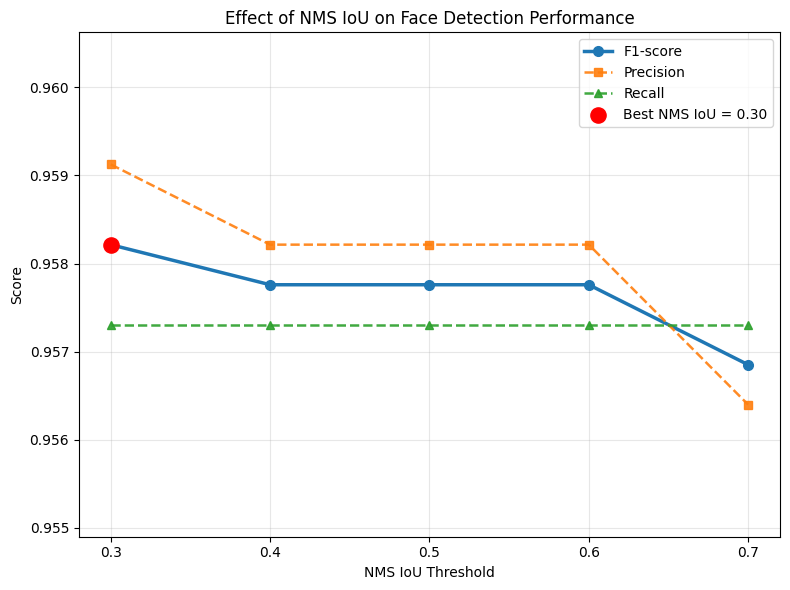

In [55]:
import matplotlib.pyplot as plt
import numpy as np

ious = df_iou["iou"].values

# En iyi NMS IoU (F1 max)
best_idx = df_iou["f1"].idxmax()
best_iou = df_iou.loc[best_idx, "iou"]
best_f1  = df_iou.loc[best_idx, "f1"]

plt.figure(figsize=(8, 6))

# 🔵 F1 (ANA METRİK)
plt.plot(
    ious,
    df_iou["f1"],
    marker="o",
    markersize=7,
    linewidth=2.5,
    label="F1-score"
)

# 🟠 Precision
plt.plot(
    ious,
    df_iou["precision"],
    marker="s",
    linestyle="--",
    linewidth=1.8,
    alpha=0.9,
    label="Precision"
)

# 🟢 Recall
plt.plot(
    ious,
    df_iou["recall"],
    marker="^",
    linestyle="--",
    linewidth=1.8,
    alpha=0.9,
    label="Recall"
)

# ⭐ En iyi nokta
plt.scatter(
    best_iou,
    best_f1,
    color="red",
    s=120,
    zorder=5,
    label=f"Best NMS IoU = {best_iou:.2f}"
)

# X ekseni: sadece gerçek deney noktaları
plt.xticks(ious)

# Y ekseni: kontrollü zoom
y_min = df_iou[["f1", "precision", "recall"]].min().min()
y_max = df_iou[["f1", "precision", "recall"]].max().max()
plt.ylim(y_min - 0.0015, y_max + 0.0015)

plt.xlabel("NMS IoU Threshold")
plt.ylabel("Score")
plt.title("Effect of NMS IoU on Face Detection Performance")

plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/nms_iou_effect.png", dpi=300, bbox_inches="tight")
plt.show()

Confidence threshold ve NMS IoU parametreleri birlikte optimize edilmiştir.
Yapılan grid search sonucunda, conf = 0.40 ve NMS IoU = 0.30 kombinasyonu,
F1 skorunu maksimize eden en uygun çalışma noktası olarak belirlenmiştir.
Bu noktada model, precision–recall dengesi açısından en iyi performansı göstermektedir.”

In [35]:
import pandas as pd


# MODEL METRİKLERİ

data = {
    "Model": ["Baseline", "Optimized"],
    "Precision": [0.9521, 0.9591],
    "Recall":    [0.9487, 0.9573],
    "F1":        [0.9504, 0.9582],
    "FPPI":      [0.1023, 0.0758],
    "MissRate":  [0.0513, 0.0427],
}

df_compare = pd.DataFrame(data)
df_compare

,Model,Precision,Recall,F1,FPPI,MissRate
0,Baseline,0.9521,0.9487,0.9504,0.1023,0.0513
1,Optimized,0.9591,0.9573,0.9582,0.0758,0.0427


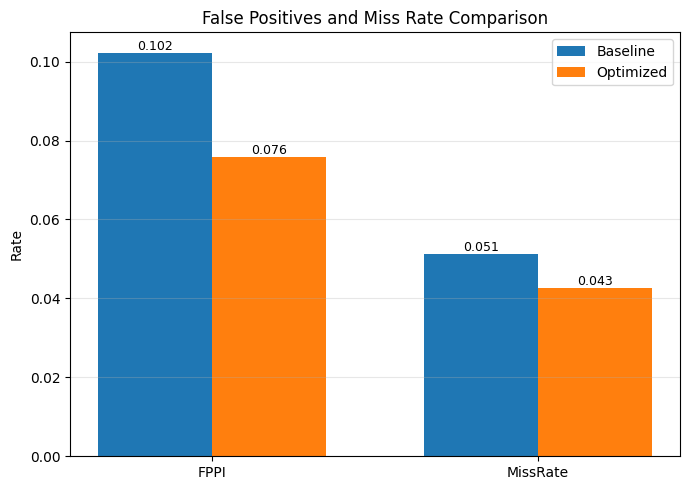

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt


FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

metrics_fp = ["FPPI", "MissRate"]
x = np.arange(len(metrics_fp))
width = 0.35

plt.figure(figsize=(7, 5))

bars1 = plt.bar(
    x - width/2,
    df_compare.loc[0, metrics_fp],
    width,
    label="Baseline"
)

bars2 = plt.bar(
    x + width/2,
    df_compare.loc[1, metrics_fp],
    width,
    label="Optimized"
)

plt.xticks(x, metrics_fp)
plt.ylabel("Rate")
plt.title("False Positives and Miss Rate Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)

# Bar üstüne değer yaz
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()

plt.savefig(
    os.path.join(FIG_DIR, "baseline_vs_optimized_fppi_missrate.png"),
    dpi=300,
    bbox_inches="tight"
)

plt.show()

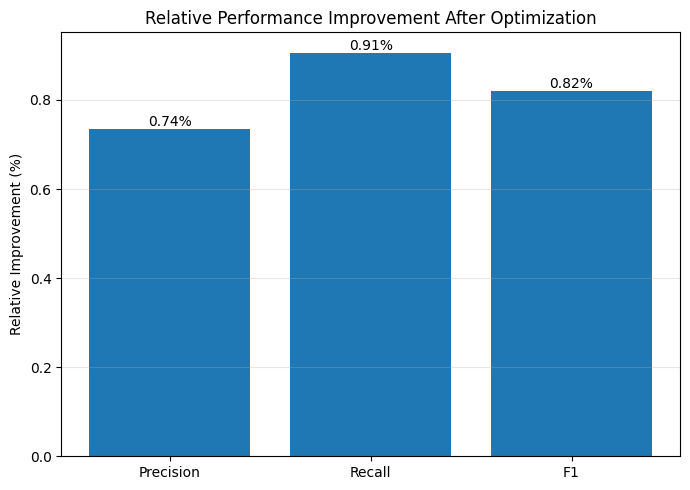

In [57]:
import os
import matplotlib.pyplot as plt

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# RELATIVE IMPROVEMENT 
improvement = {
    m: (df_compare.loc[1, m] - df_compare.loc[0, m]) / df_compare.loc[0, m] * 100
    for m in ["Precision", "Recall", "F1"]
}

plt.figure(figsize=(7, 5))

bars = plt.bar(
    improvement.keys(),
    improvement.values()
)

plt.ylabel("Relative Improvement (%)")
plt.title("Relative Performance Improvement After Optimization")
plt.grid(axis="y", alpha=0.3)

# 🔢 Bar üstüne yüzde yaz
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()

plt.savefig(
    os.path.join(FIG_DIR, "relative_improvement_metrics.png"),
    dpi=300,
    bbox_inches="tight"
)

plt.show()